# 한국은행 금융통화위원회 의사록 분석

### 금융통화위원회 의사록에 담긴 어조를 추출하여 지수로 편제하고 기준금리 변동에 대한 예측력을 검정

#### - 분석 방법 : 2008.04.01~2022.11.15에 발생한  300건의 의사록에서 추출한 n-gram을 분석하여 감성사전*을 구축
#### * 특정 n-gram(예: 금리 인상)이 지닌 polarity을 규정한 사전 (예: 금리 인상 = 매파적)

### 1) 데이터 수집 : 한국은행 금융통화위원회 의사록 웹크롤링
#### - 수집대상 : 1) 금융통화위원회 의사록 본문,  2) 금융통화위원회 날짜
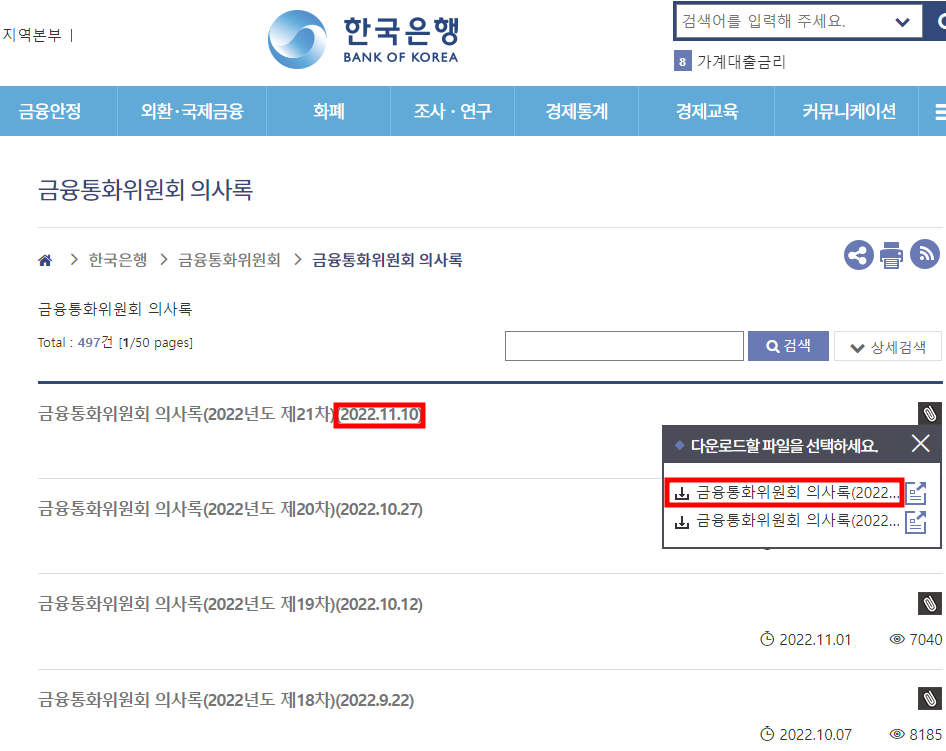

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install git+https://github.com/entelecheia/eKoNLPy.git
!pip install eKoNLPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/entelecheia/eKoNLPy.git to /tmp/pip-req-build-rc6qdj0v
  Running command git clone -q https://github.com/entelecheia/eKoNLPy.git /tmp/pip-req-build-rc6qdj0v
     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 465 kB 61.9 MB/s 
  Created wheel for eKoNLPy: filename=eKoNLPy-0.5.30-py3-none-any.whl size=14437153 sha256=221d930749a55c185aad897c68dc82f4bc2c2d31845eb5e1181aeac009269bb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-3reutoup/wheels/f9/b5/82/464285b98897813d522960b92c0e7d602eb6a407ac83d1b7cc
Successfully built eKoNLPy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [5]:
!pip install pdfplumber

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import requests
from bs4 import BeautifulSoup as bs
from urllib.request import urlretrieve
import urllib.request
import pandas as pd
import pdfplumber
import re
import os
import shutil
from ekonlpy.sentiment import MPCK
from ekonlpy.sentiment import MPKO
import nltk
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
import gensim

In [1]:
# 지정날짜에 해당하는 금통위 의사록 목록에서 의사록 pdf 다운로드 후 본문 추출
def get_mpb_minutes(start_date = '2008-04-01', end_date = '2022-11-15'):
    
    url = 'https://www.bok.or.kr/portal/bbs/B0000245/list.do?menuNo=200761&searchWrd=&searchCnd=1' 
    headers = {'user-agent' : 'Mozilla/5.0'}
    page = 1
    texts = []
    dates = []

    while True:
        params = f'&sdate={start_date}&edate={end_date}&pageIndex={str(page)}'
        resp = requests.get(url + params, headers = headers)
        soup = bs(resp.text, 'lxml')
        end_page = soup.select('.schTotal span')[-1].text.split('/')[1].replace('pages', '')
        
        if page <= int(end_page):
            print(f'{page}번째 페이지 크롤링')
            date_list = soup.select('span.titlesub')
            page_dates = [date.text.split(')')[1].replace('(','') for date in date_list]
            dates.append(page_dates)
            
            aTag_list = soup.select('.fileGoupBox a')
            href_list = [aTag.attrs['href'] for aTag in aTag_list if '.pdf' in aTag.attrs['title']] 
            for href in href_list:
                print(href)
                download_link = 'https://www.bok.or.kr' + href
                os.makedirs('/content/temp')
                urlretrieve(download_link, '/content/temp/temp.pdf')

                text = ""
                with pdfplumber.open('/content/temp/temp.pdf') as f:
                    pages = f.pages      
                    for pg in pages[1:]:
                        text += pg.extract_text().replace('\n', '')
                        text = re.sub('- \d+ -', '', text)
                shutil.rmtree('/content/temp')
                texts.append(text)
            page += 1
        else: break
            
    dates = sum(dates, [])          
    return dates, texts

In [ ]:
dates, texts = get_mpb_minutes()

1번째 페이지 크롤링
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000035091&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000034867&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000034406&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000034210&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000034051&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000033255&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000033019&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000032246&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000031946&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000031705&fileSn=2
2번째 페이지 크롤링
/portal/cmmn/file/fileDown.do?menuNo=200761&atchFileId=FILE_000000000030802&fileSn=2
/portal/cmmn/file/fileDown.do?menuNo=2007

In [ ]:
# 크롤링한 데이터 저장
with open('/content/mpb_minutes.txt', 'w') as f:
    for idx in range(len(dates)):
        f.write(dates[idx] + '@' + texts[idx] + '\t')

In [ ]:
# 텍스트 의사록별 데이터프레임화
def data_to_df(data_path):
    df = pd.read_csv(data_path, sep='\t', header=None).transpose()
    df = df[0].str.split('@', expand=True)
    df.columns = ['dates', 'docs']
    df['dates'] = pd.to_datetime(df['dates'])
    return df

In [6]:
minutes_df = data_to_df('/content/mpb_minutes.txt')
minutes_df.drop(index=300, axis=0, inplace=True)
minutes_df

,dates,docs
0,2022-10-27,1. 일 자 2022년 10월 27일(목)2. 장 소 금융통화위원회 회의실3. 출석...
1,2022-10-12,1. 일 자 2022년 10월 12일(수)2. 장 소 금융통화위원회 회의실3. 출석...
2,2022-09-22,1. 일 자 2022년 9월 22일(목)2. 장 소 금융통화위원회 회의실3. 출석위...
3,2022-09-08,1. 일 자 2022년 9월 8일(목)2. 장 소 금융통화위원회 회의실3. 출석위원...
4,2022-08-25,1. 일 자 2022년 8월 25일(목)2. 장 소 금융통화위원회 회의실3. 출석위...
...,...,...
295,2008-05-08,"동향 국제국장이 보고 제 호 외환국제금융 동향 그리고 금융시장국장이, 52 - ,보..."
296,2008-04-10,본회의에서는 의장이 한국은행법 제 조에 의거하여 의안 제 호 통( ) 28 21 -...
297,2008-03-20,년도 연차보고서 안 은 공개시장조작 및 고액권 발행 준비 등 주2007 ( )요 업...
298,2008-03-07,전일 개최된 동향보고회의에서 조사국장이 보고 제 호 국내외 경제( ) 26 -동향 ...


In [ ]:
# 의사록 데이터프레임 저장
minutes_df.to_csv('minutes_df.csv', index=False)

In [16]:
# Mecab 기반의 토크나이저 사용해서 n-gram
def text_to_ngram(doc):   
    mpck = MPCK()
    tokens = mpck.tokenize(doc)
    ngrams = mpck.ngramize(tokens)
    return ngrams

In [17]:
# 의사록 본문 전처리 
def preprocessing(docs):
    docs.replace('[^0-9a-zA-Zㄱ-ㅎ가-힣,. ]', '', regex=True, inplace=True)
    docs.replace('\d+.\d*', '', regex=True, inplace=True)
    docs.replace('([a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', regex=True, inplace=True)
    docs.replace('"\.+\.', '', regex=True, inplace=True)
    docs.replace(' +', '', regex=True, inplace=True)

    doc_ngrams = []
    for doc in docs:
        doc_ngrams.append(text_to_ngram(doc))
    return doc_ngrams

### 2) 토픽 모델링 : 의사록 토픽 추출

In [ ]:
doc_ngrams = []
for doc in minutes_df.docs:
    doc_ngrams.append(text_to_ngram(doc))
dictionary = gensim.corpora.Dictionary(doc_ngrams)
corpus = [dictionary.doc2bow(ngram) for ngram in doc_ngrams] 

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=7, id2word = dictionary, passes=15)
topics = ldamodel.print_topics(num_words=1)
for topic in topics:
    print(topic)

(0, '0.002*"개선/NNG;추세/NNG" + 0.001*"잠재/NNG;위험/NNG"')
(1, '0.002*"개선/NNG;추세/NNG" + 0.001*"세계/NNG;경제/NNG;완만/NNG;회복/NNG"')
(2, '0.002*"성장/NNG;회복/NNG" + 0.001*"국제/NNG;금융시장/NNG;변동성/NNG;확대/NNG"')
(3, '0.002*"개선/NNG;추세/NNG" + 0.001*"은행/NNG;대출/NNG;확대/NNG"')
(4, '0.001*"세계/NNG;경제/NNG;회복/NNG" + 0.001*"경상/NNG;수지/NNG;흑자/NNG"')
(5, '0.002*"불확실성/NNG;증대/NNG" + 0.001*"신용/NNG;열위/NNG"')
(6, '0.002*"성장/NNG;회복/NNG" + 0.001*"거시/NNG;금융안정/NNG"')


(Text(0.5, 0, 'Number of topics'), Text(0, 0.5, 'coherence score'))

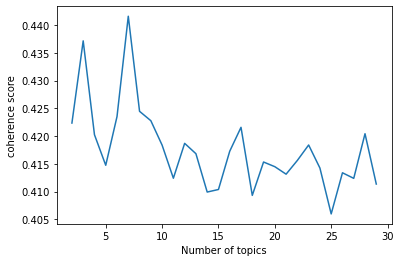

In [ ]:
coherence_values = []
for i in range(2,30):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary)
    coherence_model_lda = gensim.models.CoherenceModel(model=ldamodel, texts=doc_ngrams, dictionary=dictionary, topn=30)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

x = range(2,30)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics"), plt.ylabel("coherence score")

### 3) 감성사전 만들기

In [ ]:
def merge_call_rate(df, call_rate):
    merge_df = pd.DataFrame(preprocessing(df.docs)) 
    merge_df['date'] = df['dates']
    merge_df = pd.merge(merge_df, call_rate[['date', 'change']], on='date', how='left')
    merge_df.index.name = 'docs'
    return merge_df

In [ ]:
# 콜금리 데이터 불러오기
call_rate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/call_rate.csv', index_col=0)
call_rate['30days'] = call_rate['date'].apply(lambda x: x + relativedelta(months=1))
call_rate.date = pd.to_datetime(call_rate.date)
df = merge_call_rate(minutes_df, call_rate)
df

,0,1,2,3,4,5,6,7,8,9,...,443,444,445,446,447,448,449,450,date,change
docs,,,,,,,,,,,,,,,,,,,,,
0,회사채/NNG;스프레드/NNG;상승/NNG,고유동성/NNG;자산/NNG;확보/NNG,ecb/NNG;금리/NNG;인상/NNG,금융시장/NNG;불안/NNG,유동성/NNG;위축/NNG,한시적/VAX;완화/NNG,수익성/NNG;악화/NNG,인상/NNG;유예/NNG,금리/NNG;오르/VV,None,...,None,None,None,None,None,None,None,None,2022-10-27,down
1,물가/NNG;상승률/NNG;국제/NNG;유가/NNG;하락/NNG,글로벌/NNG;경기/NNG;둔화/NNG;금리/NNG;인상/NNG,fed/NNG;금리/NNG;인상/NNG;기대/NNG;강화/NNG,금리/NNG;상승/NNG;자산/NNG;가격/NNG;하락/NNG,국제/NNG;금융시장/NNG;안전자산/NNG;선호/NNG,외평채/NNG;cds/NNG;프리미엄/NNG;상승/NNG,국제/NNG;금융시장/NNG;변동성/NNG;확대/NNG,금융시장/NNG;안전자산/NNG;선호/NNG;높/VA,물가/NNG;소비자/NNG;물가/NNG;상승/NNG,글로벌/NNG;경기/NNG;둔화/NNG;우려/NNG,...,None,None,None,None,None,None,None,None,2022-10-12,down
2,높/VA;인플레이션/NNG;압력/NNG;금리/NNG;인상/NNG,가계/NNG;부채/NNG;질적/VAX;구조/NNG;개선/NNG,높/VA;물가/NNG;상승/NNG;압력/NNG,금융시장/NNG;변동성/NNG;확대/NNG,외환시장/NNG;변동성/NNG;확대/NNG,금리/NNG;인상/NNG;금융안정/NNG,부채/NNG;상환능력/NNG;악화/NNG,주택가격/NNG;많이/MAG;오르/VV,가격/NNG;하방/NNG;압력/NNG,민간/NNG;신용/NNG;증가/NNG,...,None,None,None,None,None,None,None,None,2022-09-22,up
3,국제/NNG;금융시장/NNG;변동성/NNG;확대/NNG,경기/NNG;하방/NNG;위험/NNG;증대/NNG,금리/NNG;인상/NNG;속도/NNG;높/VV,인플레이션/NNG;기대/NNG;안정/NNG,물가/NNG;상승/NNG;압력/NNG,높/VA;대외/NNG;불확실성/NNG,금리/NNG;인상/NNG;가속/NNG,자본/NNG;유출/NNG;압력/NNG,외환시장/NNG;안정/NNG,단기/NNG;성장/NNG,...,None,None,None,None,None,None,None,None,2022-09-08,down
4,국제/NNG;금융시장/NNG;fed/NNG;금리/NNG;인상/NNG,국고채/NNG;금리/NNG;글로벌/NNG;경기/NNG;둔화/NNG,국제/NNG;유가/NNG;원자재/NNG;가격/NNG;하락/NNG,금리/NNG;글로벌/NNG;경기/NNG;둔화/NNG;우려/NNG,글로벌/NNG;경기/NNG;둔화/NNG;우려/NNG;하락/NNG,물가/NNG;상승률/NNG;국제/NNG;유가/NNG;하락/NNG,글로벌/NNG;경기/NNG;둔화/NNG;수출/NNG;둔화/NNG,물가/NNG;상방/NNG;위험/NNG;성장/NNG;하방/NNG,상방/NNG;위험/NNG;성장/NNG;하방/NNG;위험/NNG,하방/NNG;위험/NNG;물가/NNG;상방/NNG;위험/NNG,...,None,None,None,None,None,None,None,None,2022-08-25,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,국제/NNG;금융시장/NNG;불안/NNG;경기/NNG;부진/NNG,물가/NNG;국제/NNG;원자재/NNG;가격/NNG;상승/NNG,가계/NNG;대출/NNG;증가/NNG;액/NNG;증가/NNG,글로벌/NNG;신용경색/NNG;우려/NNG;완화/NNG,국제/NNG;금융시장/NNG;불안/NNG;완화/NNG,물가/NNG;상승률/NNG;물가/NNG;안정/NNG,국제/NNG;원자재/NNG;가격/NNG;급등/NNG,소비자/NNG;물가/NNG;상승/NNG;확대/NNG,세계/NNG;경제/NNG;성장/NNG;둔화/NNG,가격/NNG;상승/NNG;물가/NNG;불안/NNG,...,None,None,None,None,None,None,None,None,2008-05-08,up
296,국제/NNG;금융시장/NNG;불안/NNG;경기/NNG;부진/NNG,국제/NNG;유가/NNG;원자재/NNG;가격/NNG;급등/NNG,물가/NNG;상승/NNG;압력/NNG;점차/MAG;완화/NNG,물가/NNG;안정/NNG;목표/NNG;상한/NNG;넘/VV,경제주체/NNG;소비/NNG;투자심리/NNG;위축/NNG,금융시장/NNG;국제/NNG;금융시장/NNG;불안/NNG,국제/NNG;금융시장/NNG;신용경색/NNG;우려/NNG,주택가격/NNG;하락/NNG;경기/NNG;침체/NNG,국제/NNG;금융시장/NNG;불안/NNG;완화/NNG,단기/NNG;금리/NNG;변동성/NNG;확대/NNG,...,None,None,None,None,None,None,None,None,2008-04-10,down
297,콜/NNG;금리/NNG;목표/NNG;인상/NNG,국제/NNG;금융시장/NNG;불안/NNG,중소기업/NNG;대출/NNG;증가/NNG,물가/NNG;오름/NNG;확대/NNG,은행/NNG;대출/NNG;확대/NNG,물가/NNG;오름/NNG;둔화/NNG,유동성/NNG;높/VA;증가/NNG,서브프라임/NNG;부실/NNG,통화/NNG;안정/NNG,물가/NNG;안정/NNG,...,None,None,None,None,None,None,None,None,2008-03-20,up


In [36]:
# 콜금리 등락 기준으로 어조 'hawkish', 'dovish' 설정
def make_polarity_lexicon(df):
    hawkish_lexicon = {}
    dovish_lexicon = {}
    for col in range(len(df)):
        for ngram in df.iloc[col,:-2]:
            if df.loc[col, 'change'] == 'up':
                hawkish_lexicon[ngram] = hawkish_lexicon.get(ngram, 0) + 1
            elif df.loc[col, 'change'] == 'down':

                dovish_lexicon[ngram] = dovish_lexicon.get(ngram, 0) + 1

    del(hawkish_lexicon[None])  
    del(dovish_lexicon[None])

    hawkish_lexicon = {key : 'hawkish' for key, value in hawkish_lexicon.items() if value > 15}
    dovish_lexicon = {key : 'dovish' for key, value in dovish_lexicon.items() if value > 15}
    polarity_lexicon = dict(hawkish_lexicon, **dovish_lexicon)
    #polarity_lexicon = [(key, value) for key, value in hawkish_lexicon.items()] + [(key, value) for key, value in dovish_lexicon.items()]
    return polarity_lexicon

In [ ]:
polarity_lexicon = make_polarity_lexicon(df)
len(polarity_lexicon)

72

### 4) 의사록별 어조 추출

In [19]:
# 나이브베이지 분류기로 어조 분류
def make_polarity_classifier(df, polarity_lexicon):
    dataset = []
    for col in range(len(df)):
        tone = {}
        for ngram in df.iloc[col,:-1]:
            if ngram in polarity_lexicon.keys():
                tone[ngram] = polarity_lexicon.get(ngram)
        if tone.keys():
            if df.iloc[col,-1] != 'same':
                dataset.append((tone, df.iloc[col,-1]))

    classifier = nltk.NaiveBayesClassifier.train(dataset)
    accuracy = nltk.classify.accuracy(classifier, dataset)
    print('Accuracy:', accuracy)

    ref_sets = defaultdict(set)
    pred_sets = defaultdict(set)
    for idx, (feats, label) in enumerate(dataset):
        ref_sets[label].add(idx)
        predicted = classifier.classify(feats)
        pred_sets[predicted].add(idx)
    print('Precision:', nltk.precision(ref_sets['up'], pred_sets['up']))
    print('Recall:', nltk.recall(ref_sets['up'], pred_sets['up']))

    return classifier

In [ ]:
classifier = make_polarity_classifier(df, polarity_lexicon)

Accuracy: 0.7021276595744681
Precision: 0.8148148148148148
Recall: 0.3013698630136986


In [79]:
# 'hawkish' 어조일 확률 구함
def merge_tone_score(df, classifier, base_rate):
    dataset = []
    for col in range(len(df)):
        tone = {}
        for ngram in df.iloc[col,:-2]:
            if ngram in polarity_lexicon.keys():
                tone[ngram] = polarity_lexicon.get(ngram)
        dataset.append((tone, df.iloc[col,-1]))

    feats = [feat for (feat, label) in dataset]
    doc_score = []
    for feat in feats:
          score = classifier.prob_classify(feat).prob('up')
          doc_score.append(score)

    df['doc_score'] = doc_score
    df = pd.merge(df, base_rate[['date', 'RATE', 'rate_change']], on='date', how='left')
    plot_df = df[['date', 'doc_score', 'RATE', 'rate_change']]
    plot_df.set_index('date', inplace=True)
    plot_df = plot_df.astype('float')
    return plot_df

In [84]:
# 기준금리 데이터 불러오기
base_rate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/base_rate.csv', index_col=0)
plot_df = merge_tone_score(df, classifier, base_rate)
plot_df

,doc_score,RATE,rate_change
date,,,
2008-02-13,0.096490,5.0,0.0
2008-03-07,0.079536,5.0,0.0
2008-03-20,0.364245,5.0,0.0
2008-04-10,0.176100,5.0,0.0
2008-05-08,0.165625,5.0,0.0
...,...,...,...
2022-08-25,0.030775,2.5,0.0
2022-09-08,0.516796,2.5,0.0
2022-09-22,0.124747,2.5,-1.0


In [86]:
plot_df.corr(method='pearson')

,doc_score,RATE,rate_change
doc_score,1.000000,0.133598,0.000307
RATE,0.133598,1.000000,0.147220
rate_change,0.000307,0.147220,1.000000


In [87]:
plot_df[['doc_score', 'RATE', 'rate_change']].corr(method='pearson')  #df1.corrwith(df['doc_score'], method = 'pearson')

,doc_score,RATE,rate_change
doc_score,1.000000,0.133598,0.000307
RATE,0.133598,1.000000,0.147220
rate_change,0.000307,0.147220,1.000000


### 5) 기준금리 예측

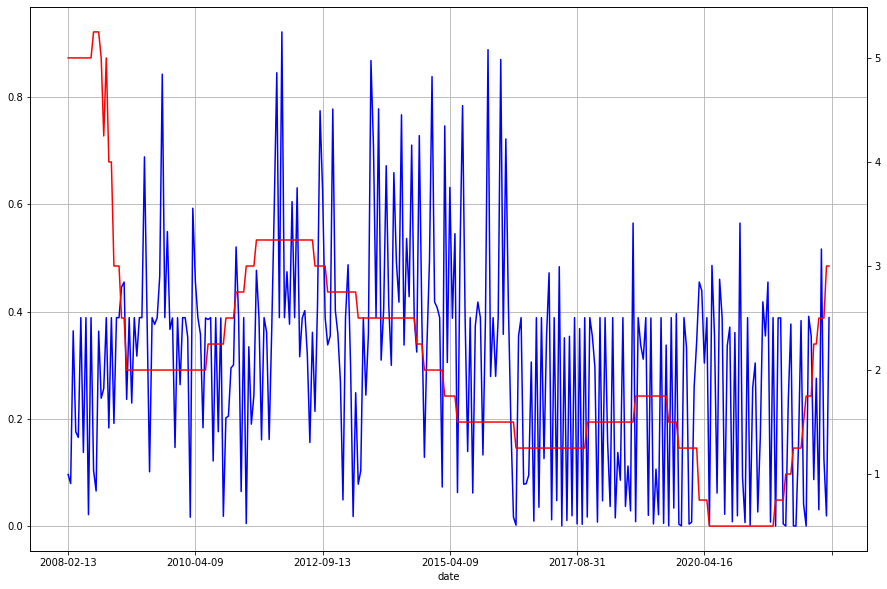

In [ ]:
#기준금리와 의사록 어조의 등락 확인
plt.figure(figsize=(15,10))
ax1 = plot_df['doc_score'].plot(color='blue', grid=True, label='금통위 의사록 어조')
ax2 = plot_df['RATE'].plot(color='red', grid=True, secondary_y=True, label='기준금리')

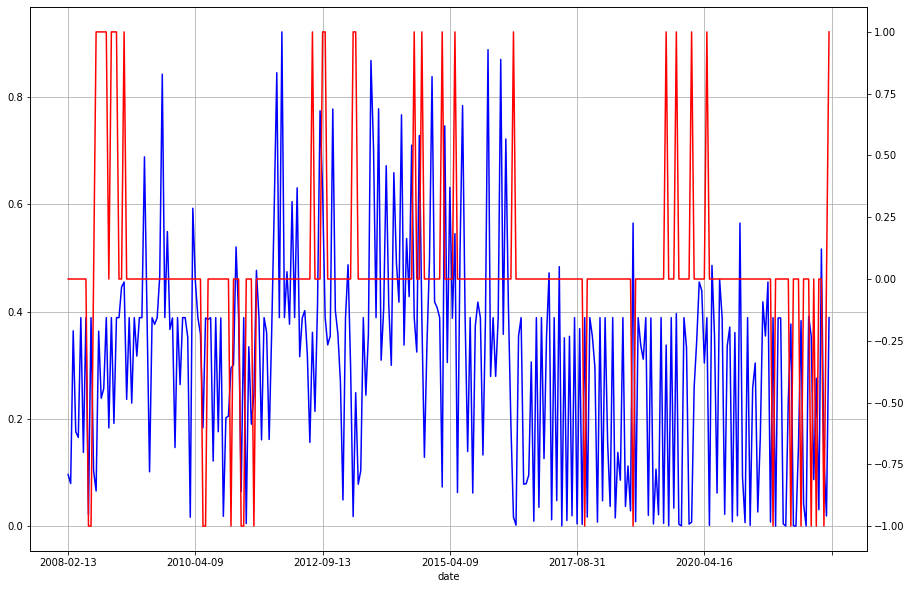

In [88]:
plt.figure(figsize=(15,10))
ax1 = plot_df['doc_score'].plot(color='blue', grid=True, label='금통위 의사록 어조')
ax2 = plot_df['rate_change'].plot(color='red', grid=True, secondary_y=True, label='기준금리')

In [ ]:
# df.drop('doc_score', axis=1, inplace=True)
# df